In [1]:
import numpy as np
import h5py
import scipy.stats as stats
import matplotlib.pyplot as plt

import illustris_python as il

In [2]:
# load cosmological data
with h5py.File("cosmology.hdf5", "r") as file:
    time = np.array(file["t"])
    redshift = np.array(file["z"])

In [3]:
# load halo properties
with h5py.File("halo_properties.hdf5", "r") as file:
    halo_mass = np.array(file["Mh"])
    stellar_mass = np.array(file["Ms"])
    gas_mass = np.array(file["Mg"])

Now we will split up the galaxy sample into 4 equally populated samples between the mass ranges $\log_{10}M_h=11$ and $\log_{10}M_h=12.5$ (at redshift 0).

In [4]:
mass_lower_bound = 11
mass_upper_bound = 12.5

mass_range = (halo_mass[:,-1] > mass_lower_bound) * (halo_mass[:,-1] < mass_upper_bound)
print(f"Number of halos in mass range: {halo_mass[mass_range].shape[0]}")

quartiles = np.percentile(halo_mass[mass_range,-1], [25, 50, 75])

first_quartile = (halo_mass[:,-1] > mass_lower_bound) * (halo_mass[:,-1] < quartiles[0])
second_quartile = (halo_mass[:,-1] > quartiles[0]) * (halo_mass[:,-1] < quartiles[1])
third_quartile = (halo_mass[:,-1] > quartiles[1]) * (halo_mass[:,-1] < quartiles[2])
fourth_quartile = (halo_mass[:,-1] > quartiles[2]) * (halo_mass[:,-1] < mass_upper_bound)

print(f"1st quartile: {halo_mass[first_quartile].shape[0]}, 2nd quartile: {halo_mass[second_quartile].shape[0]}, 3rd quartile: {halo_mass[third_quartile].shape[0]}, 4th quartile: {halo_mass[fourth_quartile].shape[0]}")

quartile_filters = [first_quartile, second_quartile, third_quartile, fourth_quartile]
bounds = [mass_lower_bound, *quartiles, mass_upper_bound]

Number of halos in mass range: 14023
1st quartile: 3506, 2nd quartile: 3505, 3rd quartile: 3505, 4th quartile: 3506


Now we create filters for selecting galaxies by the residual from the median stellar mass (1 sigma and 2 sigma).

We then calculate the median stellar mass in each filter at each timestep and plot the efficiency at each timestep.

$\varepsilon_B=\frac{M_*}{M_*+M_g}$

In [5]:
medians = np.ndarray(4)
sigmas = np.ndarray(4)
sigma_filters = []

styles = ["-", "--", ":", "-", "--", ":"]

for i, quartile in enumerate(quartile_filters):
    sigma_filter = []
    
    medians[i] = np.median(stellar_mass[quartile, -1])
    sigmas[i] = np.std(stellar_mass[quartile, -1])
    
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i]) * (stellar_mass[quartile, -1] < medians[i] + sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i] + sigmas[i]) * (stellar_mass[quartile, -1] < medians[i] + 2*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] > medians[i] + 2*sigmas[i]) * (stellar_mass[quartile, -1] < medians[i] + 3*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i]) * (stellar_mass[quartile, -1] > medians[i] - sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i] - sigmas[i]) * (stellar_mass[quartile, -1] > medians[i] - 2*sigmas[i]))
    sigma_filter.append((stellar_mass[quartile, -1] < medians[i] - 2*sigmas[i]) * (stellar_mass[quartile, -1] > medians[i] - 3*sigmas[i]))
    
    sigma_filters.append(sigma_filter)

In [6]:
# some interesting point on the plot
inflection_points = [[], [], [], [2.3, 3.5, 8.9]]  # [Gyr]

In [7]:
efficiency = np.ndarray((4, 6, 100))

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            stars = np.nanmedian(stellar_mass[quartile, k][sig_filter])
            gas = np.nanmedian(gas_mass[quartile, k][sig_filter])
            efficiency[i, j, k] = 10**stars / (10**stars + 10**gas)

/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


Text(0.5, 0, 'Age of the Universe [Gyr]')

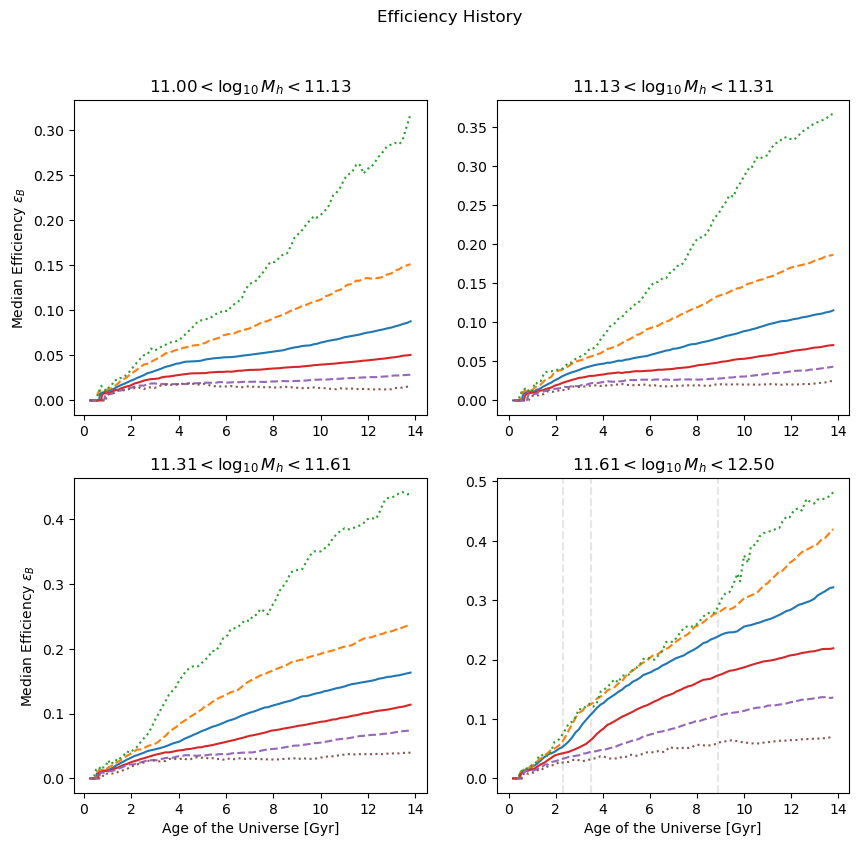

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, efficiency[i, j], linestyle=styles[j])

fig.suptitle("Efficiency History")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# fig.savefig("efficiency_history")

Text(0.5, 0, 'Age of the Universe [Gyr]')

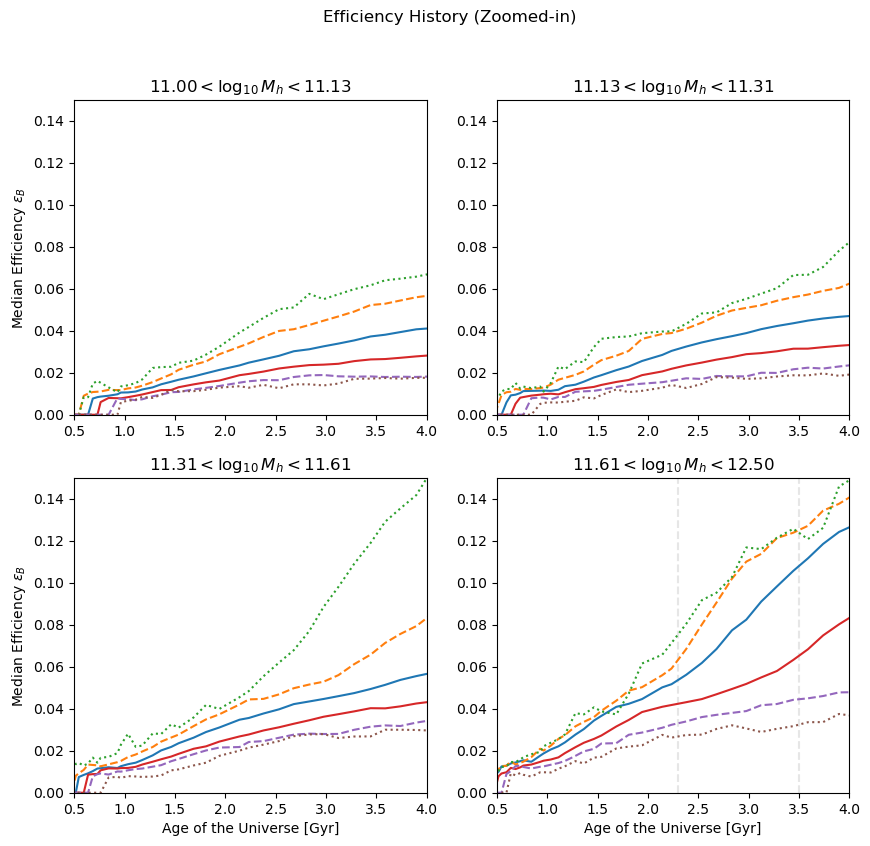

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    axes[i].set_ylim(0, 0.15)
    axes[i].set_xlim(0.5, 4)
    for j in range(6):
        axes[i].plot(time, efficiency[i, j], linestyle=styles[j])

fig.suptitle("Efficiency History (Zoomed-in)")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_ylabel("Median Efficiency $\\varepsilon_B$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# fig.savefig("efficiency_history_zoomed")

We want to plot the medians of some other quantities, number of satellites, black hole luminosity and stellar mass/gas mass.

To do this we need to get the black hole accretion rate and number of satellites from the group catalogues.

I checked the `SubhaloFlag` field but it seemed like the number of subfind halos in the group and the number of subhalos of true cosmological origin are very similar.

In [10]:
# load additional halo properties
with h5py.File("halo_properties.hdf5", "r") as file:
    bh_mdot = np.array(file["bh_mdot"])
    satellites = np.array(file["satellites"])
    beta = np.array(file["beta"])

In [11]:
# bin the properties just like efficiency above
binned_bh_mdot = np.ndarray((4, 6, 100))
binned_satellites = np.ndarray((4, 6, 100))
binned_beta = np.ndarray((4, 6, 100))

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            binned_bh_mdot[i, j, k] = np.nanmedian(bh_mdot[quartile, k][sig_filter])
            binned_satellites[i, j, k] = np.nanmedian(satellites[quartile, k][sig_filter])
            binned_beta[i, j, k] = np.nanmedian(beta[quartile, k][sig_filter])

We can convert the black hole accretion rate to an AGN luminosity by the following formula, which is derived from eq. (1) in https://doi.org/10.1093/mnras/staa1494.

$L=\frac{\varepsilon_r}{1-\varepsilon_r}\dot{M}_\text{BH}c^2$

In [12]:
e_r = 0.1  # from paper above
c = 3e8  # [m/s]
M_sol = 2e30  # [kg]
L_sol = 4e28  # [W]
Gyr = 1e9 * 365 * 24 * 3600  # [s]
conversion = M_sol / (Gyr * L_sol)

luminosity = conversion * e_r / (1 - e_r) * binned_bh_mdot * c**2

Text(0.5, 0, 'Age of the Universe [Gyr]')

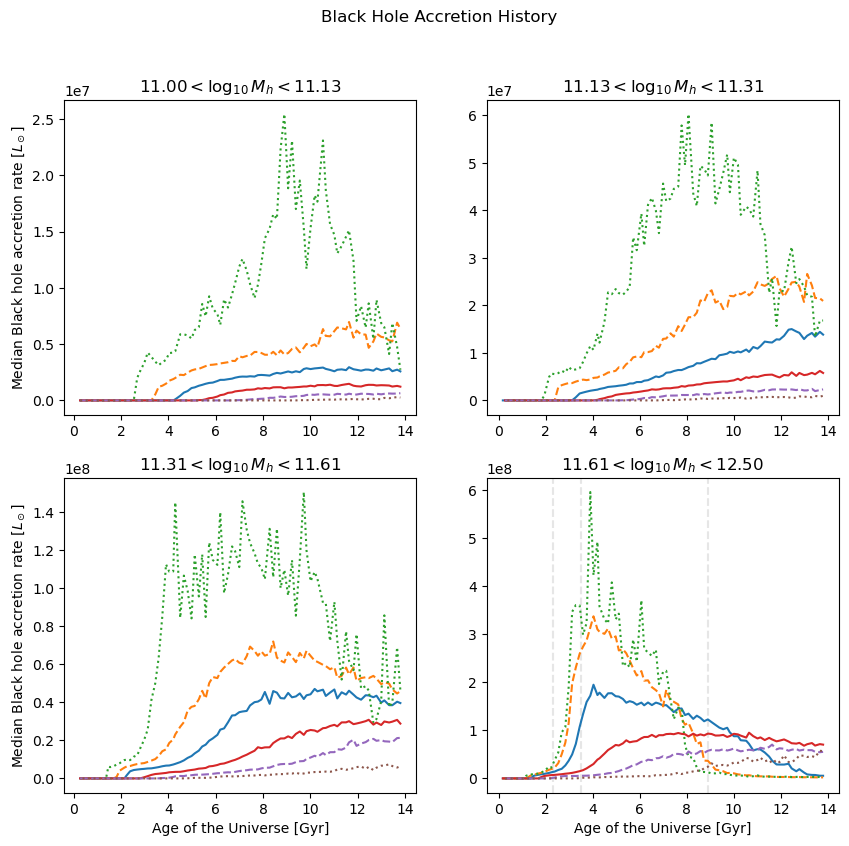

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
        
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, luminosity[i, j], linestyle=styles[j])

fig.suptitle("Black Hole Accretion History")
axes[0].set_ylabel("Median Black hole accretion rate [$L_\\odot$]")
axes[2].set_ylabel("Median Black hole accretion rate [$L_\\odot$]")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

Text(0.5, 0, 'Age of the Universe [Gyr]')

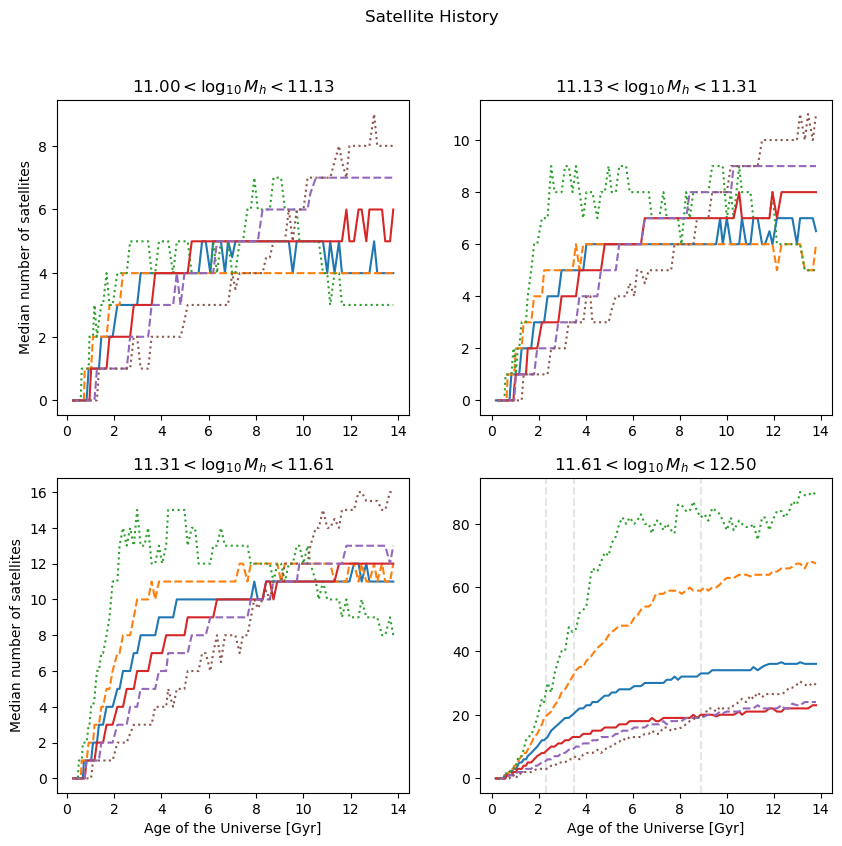

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, binned_satellites[i, j], linestyle=styles[j])

fig.suptitle("Satellite History")
axes[0].set_ylabel("Median number of satellites")
axes[2].set_ylabel("Median number of satellites")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

Text(0.5, 0, 'Age of the Universe [Gyr]')

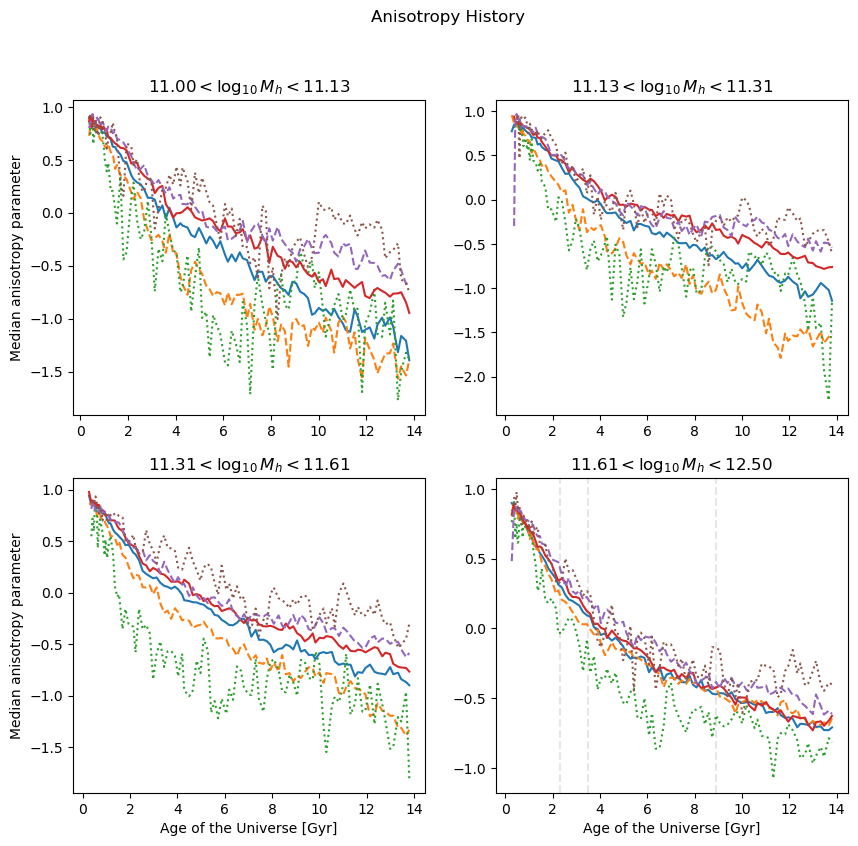

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
    
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, binned_beta[i, j], linestyle=styles[j])

fig.suptitle("Anisotropy History")
axes[0].set_ylabel("Median anisotropy parameter")
axes[2].set_ylabel("Median anisotropy parameter")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# Comparison of Mass Content over Time
Now we look at the median amount of gas and stellar material in the halos over time.

Note that the *TNG100-1* simulation has a minimum mass resolution of the order $10^6M_\odot$ for dark matter and gas, so we ignore anything below this amount.

In [16]:
binned_stellar_mass = np.ndarray((4, 6, 100))
binned_gas_mass = np.ndarray((4, 6, 100))

star_colours = ["dodgerblue", "royalblue", "midnightblue", "dodgerblue", "royalblue", "midnightblue"]
gas_colours = ["red", "firebrick", "maroon", "red", "firebrick", "maroon"]

for i, quartile in enumerate(quartile_filters):
    for j, sig_filter in enumerate(sigma_filters[i]):
        for k in range(100):
            binned_stellar_mass[i, j, k] = np.nanmedian(stellar_mass[quartile, k][sig_filter])
            binned_gas_mass[i, j, k] = np.nanmedian(gas_mass[quartile, k][sig_filter])

Text(0.5, 0, 'Age of the Universe [Gyr]')

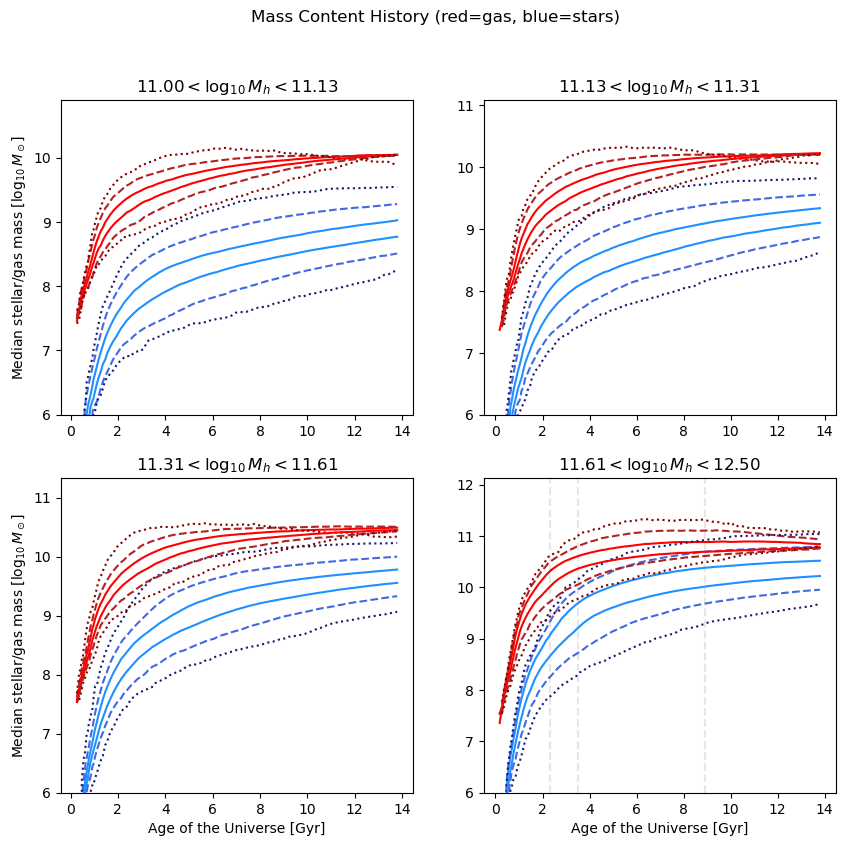

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

for i in range(4):
    for point in inflection_points[i]:
        axes[i].axvline(point, ls="--", c="0.9")
        
    axes[i].set_title(f"${bounds[i]:.2f}<\log_{{10}}M_h<{bounds[i+1]:.2f}$")
    for j in range(6):
        axes[i].plot(time, binned_stellar_mass[i, j], linestyle=styles[j], c=star_colours[j])
        axes[i].plot(time, binned_gas_mass[i, j], linestyle=styles[j], c=gas_colours[j])
    
    axes[i].set_ylim(bottom=6)  # lower mass limit in simulation

fig.suptitle("Mass Content History (red=gas, blue=stars)")
axes[0].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
axes[2].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")

# Looking at Halo Mass Bins Individually

The mass range $11.31<\log_{10}M_h<11.61$ is interesting because it is in a region of the SHMR where the scatter is particularly clear and also the plots of the median halo properties over time show some interesting features.

Text(0.5, 0, 'Age of the Universe [Gyr]')

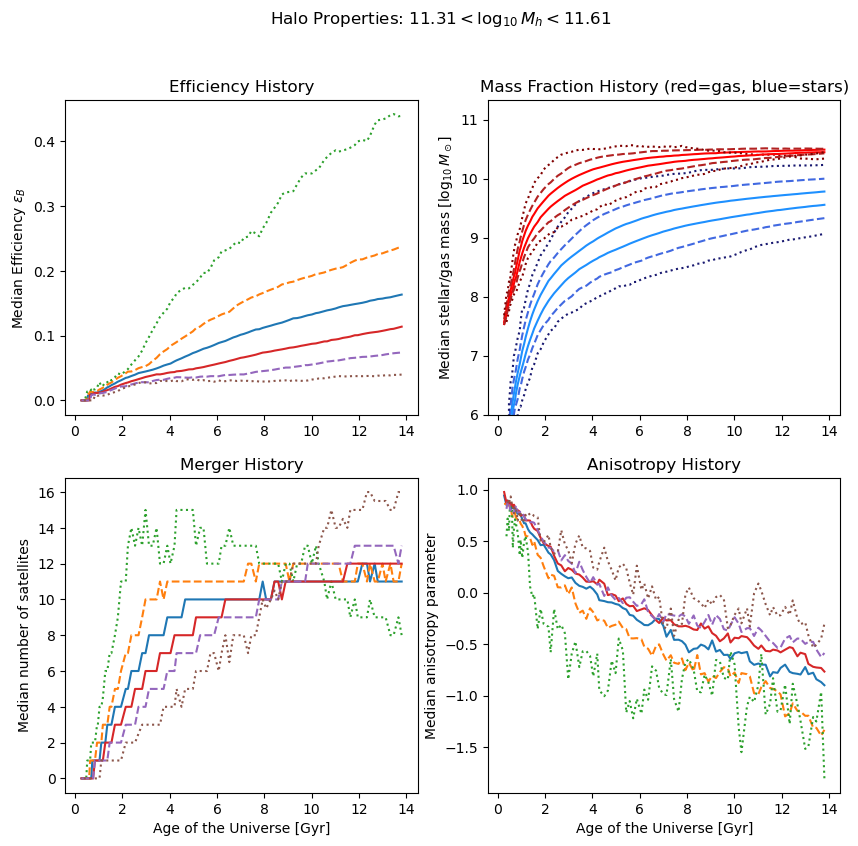

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))
axes = axes.flatten()

axes[0].set_title("Efficiency History")
axes[0].set_ylabel("Median Efficiency $\\varepsilon_B$")
for j in range(6):
    axes[0].plot(time, efficiency[2, j], linestyle=styles[j])
    
axes[1].set_title("Mass Fraction History (red=gas, blue=stars)")
axes[1].set_ylabel("Median stellar/gas mass [$\\log_{10}M_\\odot$]")
for j in range(6):
    axes[1].plot(time, binned_stellar_mass[2, j], linestyle=styles[j], c=star_colours[j])
    axes[1].plot(time, binned_gas_mass[2, j], linestyle=styles[j], c=gas_colours[j])
axes[1].set_ylim(bottom=6)

axes[2].set_title("Merger History")
axes[2].set_ylabel("Median number of satellites")
for j in range(6):
    axes[2].plot(time, binned_satellites[2, j], linestyle=styles[j])

axes[3].set_title("Anisotropy History")
axes[3].set_ylabel("Median anisotropy parameter")
for j in range(6):
    axes[3].plot(time, binned_beta[2, j], linestyle=styles[j])
    
fig.suptitle(f"Halo Properties: ${bounds[2]:.2f}<\log_{{10}}M_h<{bounds[3]:.2f}$")
axes[2].set_xlabel("Age of the Universe [Gyr]")
axes[3].set_xlabel("Age of the Universe [Gyr]")